# Instalación e importación de las librerias necesarias

In [1]:
#@title
#Ajustes
!pip install probfit
!pip install iminuit

#BLUE
!pip install blue_combine

In [2]:
#@title
#librerias necesarias
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

#Ajustes
import iminuit
import probfit
from probfit.pdf import cauchy, rtv_breitwigner, gaussian, exponential,linear
from probfit.plotting import draw_pdf
from iminuit import Minuit
from probfit import UnbinnedLH, gaussian

#Convolución
from probfit import Convolve, describe
from scipy.signal import convolve
from scipy import signal

#BLUE
import blue_combine as blue

In [3]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
datos = pd.read_csv('drive/MyDrive/datosmu.csv', sep='|')
datos

,Pt1,eta1,phi1,charge1,Pt2,eta2,phi2,charge2
0,42.990013,1.632208,-3.131952,-1,38.314686,0.636554,-0.088391,1
1,44.885010,-1.712707,-2.390203,-1,42.095661,-1.074763,0.702849,1
2,11.590354,1.795566,1.415317,1,9.162447,1.421718,-1.776640,-1
3,48.792770,-0.848226,-2.744943,-1,28.141356,-1.686511,0.543962,1
4,25.023523,0.717240,1.274220,1,20.494280,1.165218,-2.009019,-1
...,...,...,...,...,...,...,...,...
1477318,47.094326,0.596016,3.018140,-1,44.204735,1.115671,-0.833722,1
1477319,30.643383,0.583953,-2.411841,-1,29.645113,-0.729631,0.713865,1
1477320,34.627579,-0.797709,2.482613,-1,27.369417,-1.419091,-0.356188,1
1477321,6.498863,0.133503,2.558601,-1,6.203298,-1.686684,-0.531604,1


La magnitud del momento lineal |**$p$**| se puede obtener a partir de la magnitud del momento transverso |**$p_T$**| y la pseudo rapidez $\eta$:
$$|\textbf{p}|=|\textbf{p}_T|\ cosh\eta$$

In [5]:
#@title
#Construyendo |P|
datos['p1'] = datos['Pt1']*np.cosh(datos['eta1'])
datos['p2'] = datos['Pt2']*np.cosh(datos['eta2'])

La masa del muón...

In [6]:
#Masa del muon GeV/c2
mu= 0.1056583745

Conocida la masa en reposo del muón $m_0$, su energía (y la del antimoún) se puede obtener mediante la relación:
$$ m_0^2c^2=\frac{E^2}{c^2}-|\textbf{p}|^2$$
la cual, con $c=1$, toma la forma:
 $$ E = \sqrt{| \textbf{p}|^2+m_0^2} $$

In [7]:
#@title
#Construyendo E
datos['E1'] = np.sqrt(datos['p1']**2+mu**2)
datos['E2'] = np.sqrt(datos['p2']**2+mu**2)

Las componentes del momento lineal de los muones en coordenadas cartesianas son (con $|\textbf{p}_T| = p_T$):

$$p_x= p_T\ cos\phi \\
p_y=p_T\ sin\phi\\
p_z= p_T\ sinh\eta$$

In [8]:
#@title
datos['p1x']=datos['Pt1']*np.cos(datos['phi1'])  ##PHI ESTA EN RADIANES O GRADOS? PT está en que unidades?
datos['p2x']=datos['Pt2']*np.cos(datos['phi2'])
datos['ptotalx']=datos['p1x']+datos['p2x']

datos['p1y']=datos['Pt1']*np.sin(datos['phi1']) 
datos['p2y']=datos['Pt2']*np.sin(datos['phi2'])
datos['ptotaly']=datos['p1y']+datos['p2y']

datos['p1z']=datos['Pt1']*np.sinh(datos['eta1']) 
datos['p2z']=datos['Pt2']*np.sinh(datos['eta2'])
datos['ptotalz']=datos['p1z']+datos['p2z']

La masa invariante del bosón Z, $M$, se puede obtener en términos de los valores proporcionados para los muones, mediante la relación:
$$    M^2c^2=\frac{(E_1+E_2)^2}{c^2}-|\textbf{p}_1+\textbf{p}_2|^2$$
donde los subíndices $1$ y $2$ hacen referencia a muón y antimuón respectivamente. Haciendo $c=1$ la masa del bosón es:
$$    M= \sqrt{  (E_1+E_2)^2-|\textbf{p}_1+\textbf{p}_2|^2}$$

In [9]:
#@title
datos['M']=np.sqrt((datos['E1']+datos['E2'])**2-(datos['ptotalx'])**2-(datos['ptotaly'])**2-(datos['ptotalz'])**2)
datos.head()

,Pt1,eta1,phi1,charge1,Pt2,eta2,phi2,charge2,p1,p2,E1,E2,p1x,p2x,ptotalx,p1y,p2y,ptotaly,p1z,p2z,ptotalz,M
0,42.990013,1.632208,-3.131952,-1,38.314686,0.636554,-0.088391,1,114.152490,46.342943,114.152539,46.343064,-42.988015,38.165106,-4.822909,-0.414454,-3.382277,-3.796731,105.748049,26.070160,131.818209,91.351644
1,44.885010,-1.712707,-2.390203,-1,42.095661,-1.074763,0.702849,1,128.468223,68.840657,128.468266,68.840738,-32.799313,32.119148,-0.680165,-30.640972,27.210384,-3.430587,-120.372007,-54.470096,-174.842103,91.372044
2,11.590354,1.795566,1.415317,1,9.162447,1.421718,-1.776640,-1,35.865867,20.091099,35.866023,20.091377,1.794814,-1.872745,-0.077931,11.450544,-8.969017,2.481527,33.941481,17.880208,51.821689,20.966142
3,48.792770,-0.848226,-2.744943,-1,28.141356,-1.686511,0.543962,1,67.423644,78.595557,67.423726,78.595628,-45.004518,24.079565,-20.924953,-18.850140,14.564011,-4.286129,-46.531852,-73.384778,-119.916631,80.532161
4,25.023523,0.717240,1.274220,1,20.494280,1.165218,-2.009019,-1,31.740699,36.054321,31.740874,36.054476,7.313076,-8.696347,-1.383270,23.931060,-18.557722,5.373338,19.526782,29.663084,49.189866,46.322569


In [10]:
#Se seleccionan los datos de interés
datos = datos[(abs(datos['M'] >= 80)) & (abs(datos['M'] <= 100))]

## Ajuste Gaussiano sin Background

((array([80.00017923, 80.2001743 , 80.40016936, 80.60016443, 80.80015949,
         81.00015456, 81.20014962, 81.40014469, 81.60013975, 81.80013482,
         82.00012988, 82.20012495, 82.40012001, 82.60011507, 82.80011014,
         83.0001052 , 83.20010027, 83.40009533, 83.6000904 , 83.80008546,
         84.00008053, 84.20007559, 84.40007066, 84.60006572, 84.80006079,
         85.00005585, 85.20005091, 85.40004598, 85.60004104, 85.80003611,
         86.00003117, 86.20002624, 86.4000213 , 86.60001637, 86.80001143,
         87.0000065 , 87.20000156, 87.39999663, 87.59999169, 87.79998675,
         87.99998182, 88.19997688, 88.39997195, 88.59996701, 88.79996208,
         88.99995714, 89.19995221, 89.39994727, 89.59994234, 89.7999374 ,
         89.99993247, 90.19992753, 90.3999226 , 90.59991766, 90.79991272,
         90.99990779, 91.19990285, 91.39989792, 91.59989298, 91.79988805,
         91.99988311, 92.19987818, 92.39987324, 92.59986831, 92.79986337,
         92.99985844, 93.1998535 , 93.

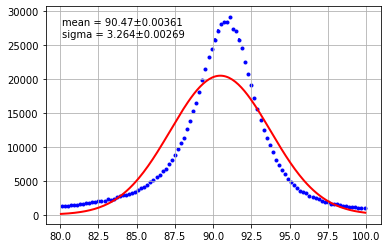

In [11]:
#@title
bound = (80, 100) #intervalor alrededor de la masa
data = datos['M'] 
Gaussiana = probfit.Normalized(gaussian, bound) #se normaliza la fdp 
GaussianasinBgd = UnbinnedLH(Gaussiana, data.values) #Construct -log(unbinned likelihood) from callable f and data points data
#f callable object. PDF that describe the data. (en nuestro caso f=BW)  

minuit_gaussian_sinBgd = Minuit(GaussianasinBgd, mean=90.5, sigma=3.0) #Function minimizer and error computer.

minuit_gaussian_sinBgd.migrad() #Run Migrad minimization.
GaussianasinBgd.draw(minuit_gaussian_sinBgd)

In [12]:
#@title
#se extraen los datos del ajuste para graficar
Masasxaxis = np.array([80.050178  , 80.15017553, 80.25017306, 80.3501706 , 80.45016813,
         80.55016566, 80.65016319, 80.75016073, 80.85015826, 80.95015579,
         81.05015332, 81.15015086, 81.25014839, 81.35014592, 81.45014345,
         81.55014099, 81.65013852, 81.75013605, 81.85013358, 81.95013111,
         82.05012865, 82.15012618, 82.25012371, 82.35012124, 82.45011878,
         82.55011631, 82.65011384, 82.75011137, 82.85010891, 82.95010644,
         83.05010397, 83.1501015 , 83.25009903, 83.35009657, 83.4500941 ,
         83.55009163, 83.65008916, 83.7500867 , 83.85008423, 83.95008176,
         84.05007929, 84.15007683, 84.25007436, 84.35007189, 84.45006942,
         84.55006695, 84.65006449, 84.75006202, 84.85005955, 84.95005708,
         85.05005462, 85.15005215, 85.25004968, 85.35004721, 85.45004475,
         85.55004228, 85.65003981, 85.75003734, 85.85003487, 85.95003241,
         86.05002994, 86.15002747, 86.250025  , 86.35002254, 86.45002007,
         86.5500176 , 86.65001513, 86.75001267, 86.8500102 , 86.95000773,
         87.05000526, 87.15000279, 87.25000033, 87.34999786, 87.44999539,
         87.54999292, 87.64999046, 87.74998799, 87.84998552, 87.94998305,
         88.04998059, 88.14997812, 88.24997565, 88.34997318, 88.44997072,
         88.54996825, 88.64996578, 88.74996331, 88.84996084, 88.94995838,
         89.04995591, 89.14995344, 89.24995097, 89.34994851, 89.44994604,
         89.54994357, 89.6499411 , 89.74993864, 89.84993617, 89.9499337 ,
         90.04993123, 90.14992876, 90.2499263 , 90.34992383, 90.44992136,
         90.54991889, 90.64991643, 90.74991396, 90.84991149, 90.94990902,
         91.04990656, 91.14990409, 91.24990162, 91.34989915, 91.44989668,
         91.54989422, 91.64989175, 91.74988928, 91.84988681, 91.94988435,
         92.04988188, 92.14987941, 92.24987694, 92.34987448, 92.44987201,
         92.54986954, 92.64986707, 92.7498646 , 92.84986214, 92.94985967,
         93.0498572 , 93.14985473, 93.24985227, 93.3498498 , 93.44984733,
         93.54984486, 93.6498424 , 93.74983993, 93.84983746, 93.94983499,
         94.04983252, 94.14983006, 94.24982759, 94.34982512, 94.44982265,
         94.54982019, 94.64981772, 94.74981525, 94.84981278, 94.94981032,
         95.04980785, 95.14980538, 95.24980291, 95.34980044, 95.44979798,
         95.54979551, 95.64979304, 95.74979057, 95.84978811, 95.94978564,
         96.04978317, 96.1497807 , 96.24977824, 96.34977577, 96.4497733 ,
         96.54977083, 96.64976837, 96.7497659 , 96.84976343, 96.94976096,
         97.04975849, 97.14975603, 97.24975356, 97.34975109, 97.44974862,
         97.54974616, 97.64974369, 97.74974122, 97.84973875, 97.94973629,
         98.04973382, 98.14973135, 98.24972888, 98.34972641, 98.44972395,
         98.54972148, 98.64971901, 98.74971654, 98.84971408, 98.94971161,
         99.04970914, 99.14970667, 99.24970421, 99.34970174, 99.44969927,
         99.5496968 , 99.64969433, 99.74969187, 99.8496894 , 99.94968693])

GAUSSIANyaxis = np.array([  125.18497066,   137.98879112,   151.95945909,   167.18756752,
           183.76911769,   201.8056831 ,   221.40456216,   242.67891786,
           265.7479022 ,   290.73676324,   317.77693245,   347.00608994,
           378.56820514,   412.61355046,   449.29868521,   488.78640732,
           531.24567026,   576.85146235,   625.78464617,   678.23175525,
           734.38474578,   794.44070091,   858.60148533,   927.07334822,
          1000.06647238,  1077.79446823,  1160.47381085,  1248.32321913,
          1341.56297607,  1440.41418965,  1545.09799421,  1655.83469236,
          1772.84283831,  1896.33826341,  2026.5330457 ,  2163.63442533,
          2307.84366854,  2459.35488312,  2618.35378912,  2785.01644883,
          2959.50796086,  3141.98112349,  3332.57507315,  3531.4139043 ,
          3738.6052777 ,  3954.23902426,  4178.38575244,  4411.09546736,
          4652.39621041,  4902.29272824,  5160.76518062,  5427.76789662,
          5703.22818896,  5987.0452365 ,  6279.08904469,  6579.19949408,
          6887.18548663,  7202.82419967,  7525.86045676,  7856.00622467,
          8192.94024512,  8536.30780942,  8885.7206836 ,  9240.75719089,
          9600.96245769,  9965.84882825, 10334.8964525 , 10707.55405039,
         11083.23985493, 11461.34273539, 11841.22350048, 12222.21638045,
         12603.63068586, 12984.75263912, 13364.8473741 , 13743.16109758,
         14118.92340502, 14491.34974202, 14859.64400149, 15223.00124547,
         15580.61053938, 15931.65788532, 16275.32924024, 16610.81360376,
         16937.30615959, 17254.01145388, 17560.14659323, 17854.9444445 ,
         18137.65681834, 18407.55761802, 18663.94593522, 18906.14907424,
         19133.52548655, 19345.46759771, 19541.40450936, 19720.80455933,
         19883.17772401, 20028.0778476 , 20155.10468418, 20263.90573952,
         20354.1779007 , 20425.66884299, 20478.17820501, 20511.55852424,
         20525.7159271 , 20520.61056872, 20496.25681983, 20452.72319936,
         20390.1320532 , 20308.65898139, 20208.53201723, 20090.03056394,
         19953.48409565, 19799.27063117, 19627.81499058, 19439.58684573,
         19235.09857721, 19014.90295156, 18779.59063334, 18529.78754777,
         18266.1521104 , 17989.37234093, 17700.16287892, 17399.26191934,
         17087.42808637, 16765.4372639 , 16434.07940106, 16094.15531119,
         15746.47348199, 15391.84691467, 15031.09000887, 14665.01550984,
         14294.43153339, 13920.13868336, 13542.92727541, 13163.57467975,
         12782.84279466, 12401.47566099, 12020.19722726, 11639.70927309,
         11260.689498  , 10883.78978086, 10509.63461446, 10138.81971792,
          9771.91082892,  9409.44267602,  9051.91813054,  8699.80753617,
          8353.54821336,  8013.54413466,  7680.16576611,  7353.750069  ,
          7034.60065533,  6722.98808997,  6419.15033133,  6123.29330236,
          5835.59158277,  5556.18921337,  5285.20060278,  5022.71152684,
          4768.78021067,  4523.43848363,  4286.69299693,  4058.52649434,
          3838.89912606,  3627.74979646,  3424.99753646,  3230.54289165,
          3044.2693178 ,  2866.04457559,  2695.72211709,  2533.14245684,
          2378.13452092,  2230.51696804,  2090.09947706,  1956.68399591,
          1830.06594772,  1710.03539002,  1596.37812384,  1488.87674993,
          1387.31166972,  1291.46202931,  1201.10660523,  1116.02463104,
          1035.99656442,   960.80479478,   890.23429166,   824.07319477,
           762.11334659,   704.150769  ,   649.98608534,   599.42488988,
           552.27806662,   508.36205956,   467.49909687,   429.51737124,
           394.25117898,   361.54102047,   331.23366451,   303.18217914])

In [13]:
# @title
#parámetros del ajuste gaussiano sin background
media_SinBgd = minuit_gaussian_sinBgd.fitarg['mean'] 
sigma_SinBgd = minuit_gaussian_sinBgd.fitarg['sigma']
err_media_SinBgd = minuit_gaussian_sinBgd.fitarg['error_mean'] 
err_sigma_SinBgd = minuit_gaussian_sinBgd.fitarg['error_sigma']
minuit_gaussian_sinBgd.fitarg

{'error_mean': 0.003610468015885384,
 'error_sigma': 0.002689999029230943,
 'fix_mean': False,
 'fix_sigma': False,
 'limit_mean': None,
 'limit_sigma': None,
 'mean': 90.47342130589746,
 'sigma': 3.2637505236542004}

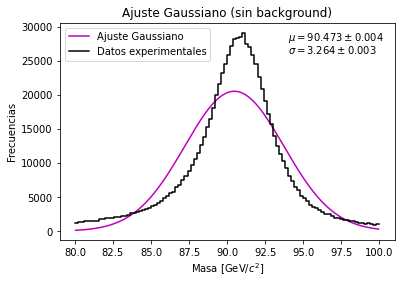

In [14]:
#@title
plt.figure()
plt.title('Ajuste Gaussiano (sin background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis,GAUSSIANyaxis,c='m',label='Ajuste Gaussiano')
bins, edges = np.histogram(data, 100) #100 bins por default en el ajuste con minuit
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.text(94,28000,f'$\mu = {media_SinBgd:.3f} \pm {err_media_SinBgd:.3f}$')
plt.text(94,26000,f'$\sigma = {sigma_SinBgd:.3f} \pm {err_sigma_SinBgd:.3f}$')
plt.legend()
plt.show()

## Ajuste a Breit-Wigner sin Background

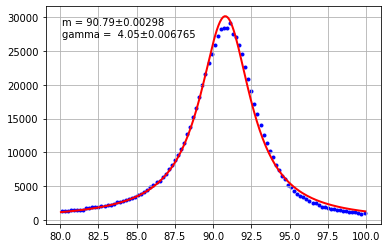

((array([80.00017923, 80.2001743 , 80.40016936, 80.60016443, 80.80015949,
         81.00015456, 81.20014962, 81.40014469, 81.60013975, 81.80013482,
         82.00012988, 82.20012495, 82.40012001, 82.60011507, 82.80011014,
         83.0001052 , 83.20010027, 83.40009533, 83.6000904 , 83.80008546,
         84.00008053, 84.20007559, 84.40007066, 84.60006572, 84.80006079,
         85.00005585, 85.20005091, 85.40004598, 85.60004104, 85.80003611,
         86.00003117, 86.20002624, 86.4000213 , 86.60001637, 86.80001143,
         87.0000065 , 87.20000156, 87.39999663, 87.59999169, 87.79998675,
         87.99998182, 88.19997688, 88.39997195, 88.59996701, 88.79996208,
         88.99995714, 89.19995221, 89.39994727, 89.59994234, 89.7999374 ,
         89.99993247, 90.19992753, 90.3999226 , 90.59991766, 90.79991272,
         90.99990779, 91.19990285, 91.39989792, 91.59989298, 91.79988805,
         91.99988311, 92.19987818, 92.39987324, 92.59986831, 92.79986337,
         92.99985844, 93.1998535 , 93.

In [15]:
# @title
BreitWigner = probfit.Normalized(rtv_breitwigner, bound) #se normaliza la fdp 
BreitWignersinBgd = UnbinnedLH(BreitWigner, data.values) #Construct -log(unbinned likelihood) from callable f and data points data
#f callable object. PDF that describe the data. (en nuestro caso f=BW)
                                 
minuit_BW_sinBgd = Minuit(BreitWignersinBgd, m=90.5, gamma=3.0) #Function minimizer and error computer.

minuit_BW_sinBgd.migrad() #Run Migrad minimization.
BreitWignersinBgd.show(minuit_BW_sinBgd) #Grafica

In [16]:
#@title
#se extraen los datos para graficar
Masasxaxis = np.array([80.050178  , 80.15017553, 80.25017306, 80.3501706 , 80.45016813,
         80.55016566, 80.65016319, 80.75016073, 80.85015826, 80.95015579,
         81.05015332, 81.15015086, 81.25014839, 81.35014592, 81.45014345,
         81.55014099, 81.65013852, 81.75013605, 81.85013358, 81.95013111,
         82.05012865, 82.15012618, 82.25012371, 82.35012124, 82.45011878,
         82.55011631, 82.65011384, 82.75011137, 82.85010891, 82.95010644,
         83.05010397, 83.1501015 , 83.25009903, 83.35009657, 83.4500941 ,
         83.55009163, 83.65008916, 83.7500867 , 83.85008423, 83.95008176,
         84.05007929, 84.15007683, 84.25007436, 84.35007189, 84.45006942,
         84.55006695, 84.65006449, 84.75006202, 84.85005955, 84.95005708,
         85.05005462, 85.15005215, 85.25004968, 85.35004721, 85.45004475,
         85.55004228, 85.65003981, 85.75003734, 85.85003487, 85.95003241,
         86.05002994, 86.15002747, 86.250025  , 86.35002254, 86.45002007,
         86.5500176 , 86.65001513, 86.75001267, 86.8500102 , 86.95000773,
         87.05000526, 87.15000279, 87.25000033, 87.34999786, 87.44999539,
         87.54999292, 87.64999046, 87.74998799, 87.84998552, 87.94998305,
         88.04998059, 88.14997812, 88.24997565, 88.34997318, 88.44997072,
         88.54996825, 88.64996578, 88.74996331, 88.84996084, 88.94995838,
         89.04995591, 89.14995344, 89.24995097, 89.34994851, 89.44994604,
         89.54994357, 89.6499411 , 89.74993864, 89.84993617, 89.9499337 ,
         90.04993123, 90.14992876, 90.2499263 , 90.34992383, 90.44992136,
         90.54991889, 90.64991643, 90.74991396, 90.84991149, 90.94990902,
         91.04990656, 91.14990409, 91.24990162, 91.34989915, 91.44989668,
         91.54989422, 91.64989175, 91.74988928, 91.84988681, 91.94988435,
         92.04988188, 92.14987941, 92.24987694, 92.34987448, 92.44987201,
         92.54986954, 92.64986707, 92.7498646 , 92.84986214, 92.94985967,
         93.0498572 , 93.14985473, 93.24985227, 93.3498498 , 93.44984733,
         93.54984486, 93.6498424 , 93.74983993, 93.84983746, 93.94983499,
         94.04983252, 94.14983006, 94.24982759, 94.34982512, 94.44982265,
         94.54982019, 94.64981772, 94.74981525, 94.84981278, 94.94981032,
         95.04980785, 95.14980538, 95.24980291, 95.34980044, 95.44979798,
         95.54979551, 95.64979304, 95.74979057, 95.84978811, 95.94978564,
         96.04978317, 96.1497807 , 96.24977824, 96.34977577, 96.4497733 ,
         96.54977083, 96.64976837, 96.7497659 , 96.84976343, 96.94976096,
         97.04975849, 97.14975603, 97.24975356, 97.34975109, 97.44974862,
         97.54974616, 97.64974369, 97.74974122, 97.84973875, 97.94973629,
         98.04973382, 98.14973135, 98.24972888, 98.34972641, 98.44972395,
         98.54972148, 98.64971901, 98.74971654, 98.84971408, 98.94971161,
         99.04970914, 99.14970667, 99.24970421, 99.34970174, 99.44969927,
         99.5496968 , 99.64969433, 99.74969187, 99.8496894 , 99.94968693])
BWyaxis = np.array([ 1162.93082181,  1182.69216867,  1202.98005062,  1223.8132632 ,
          1245.21143951,  1267.19509487,  1289.78567409,  1313.00560177,
          1336.87833573,  1361.42842376,  1386.68156405,  1412.66466943,
          1439.40593582,  1466.93491502,  1495.28259239,  1524.4814696 ,
          1554.56565289,  1585.57094724,  1617.5349569 ,  1650.49719281,
          1684.49918735,  1719.584617  ,  1755.79943358,  1793.19200472,
          1831.81326419,  1871.71687303,  1912.95939214,  1955.60046746,
          1999.70302857,  2045.33350183,  2092.56203936,  2141.46276499,
          2192.1140386 ,  2244.5987405 ,  2299.00457727,  2355.4244111 ,
          2413.9566143 ,  2474.70545132,  2537.78149045,  2603.30204769,
          2671.3916655 ,  2742.18262933,  2815.81552515,  2892.43984121,
          2972.21461801,  3055.3091501 ,  3141.9037443 ,  3232.1905386 ,
          3326.37438696,  3424.67381489,  3527.32205159,  3634.56814427,
          3746.67816087,  3863.9364874 ,  3986.64722637,  4115.1357029 ,
          4249.75008486,  4390.86312332,  4538.87401903,  4694.21041972,
          4857.33055207,  5028.72549014,  5208.92155981,  5398.4828753 ,
          5598.01399953,  5808.16271401,  6029.62287632,  6263.13733343,
          6509.50084586,  6769.56296192,  7044.23076003,  7334.47135119,
          7641.31400109,  7965.8516902 ,  8309.24188008,  8672.70619183,
          9057.52862718,  9465.0518713 ,  9896.67110707, 10353.82464196,
         10837.98049908, 11350.61795428, 11893.20281379, 12467.15502827,
         13073.80704044, 13714.35108554, 14389.77353511, 15100.77434168,
         15847.66976588, 16630.27693242, 17447.77947333, 18298.57470017,
         19180.10453822, 20088.67497749, 21019.27212611, 21965.38706609,
         22918.86640934, 23869.81027539, 24806.5435721 , 25715.68881006,
         26582.36779125, 27390.55389494, 28123.58520195, 28764.8311194 ,
         29298.48273433, 29710.41289289, 29989.03067784, 30126.0420193 ,
         30117.02837323, 29961.77103152, 29664.27828181, 29232.51108264,
         28677.8423603 , 28014.31735462, 27257.80160033, 26425.10673522,
         25533.17386427, 24598.37402922, 23635.96095728, 22659.68775394,
         21681.58010123, 20711.8455004 , 19758.89121596, 18829.42182933,
         17928.58920706, 17060.17172526, 16226.76451551, 15429.96741918,
         14670.56171883, 13948.6703056 , 13263.89868645, 12615.45620105,
         12002.25812856, 11423.01016124, 10876.2771386 , 10360.53808623,
          9874.2295797 ,  9415.77932393,  8983.63165127,  8576.26643174,
          8192.21267695,  7830.05791916,  7488.45426562,  7166.12186817,
          6861.85041086,  6574.49910124,  6302.99555398,  6046.33387454,
          5803.57218509,  5573.8297811 ,  5356.28406406,  5150.16736118,
          4954.76371553,  4769.40570829,  4593.47135784,  4426.38112697,
          4267.5950593 ,  4116.61005808,  3972.95731437,  3836.19988736,
          3705.93043598,  3581.7690987 ,  3463.3615165 ,  3350.37699323,
          3242.50678636,  3139.46252106,  3040.97472016,  2946.79144283,
          2856.67702449,  2770.41091118,  2687.78658165,  2608.61055062,
          2532.70144752,  2459.88916468,  2390.01406999,  2322.92627884,
          2258.48498093,  2196.5578176 ,  2137.02030576,  2079.75530472,
          2024.65252265,  1971.60805949,  1920.52398348,  1871.3079387 ,
          1823.87278107,  1778.13624083,  1734.02060918,  1691.45244738,
          1650.36231652,  1610.68452633,  1572.35690167,  1535.32056522,
          1499.51973528,  1464.90153743,  1431.41582904,  1399.01503573,
          1367.65399881,  1337.28983287,  1307.88179294,  1279.39115029])

In [17]:
#@title
#se extran los valores del ajuste a Breit-Wigner
gamma_SinBgd = minuit_BW_sinBgd.fitarg['gamma'] 
m_SinBgd = minuit_BW_sinBgd.fitarg['m']
err_gamma_SinBgd = minuit_BW_sinBgd.fitarg['error_gamma'] 
err_m_SinBgd = minuit_BW_sinBgd.fitarg['error_m']
minuit_BW_sinBgd.fitarg

{'error_gamma': 0.006764534632383665,
 'error_m': 0.002979515138406667,
 'fix_gamma': False,
 'fix_m': False,
 'gamma': 4.049879731606037,
 'limit_gamma': None,
 'limit_m': None,
 'm': 90.79378811947595}

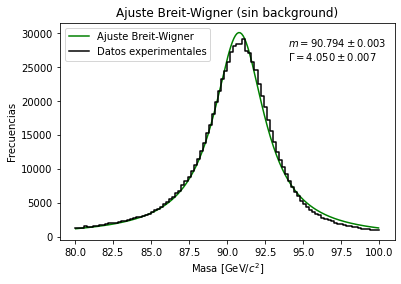

In [18]:
#@title
plt.figure()
plt.title('Ajuste Breit-Wigner (sin background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis,BWyaxis,c='g',label='Ajuste Breit-Wigner')
bins, edges = np.histogram(data, 100) #100 bins por default en el ajuste con minuit
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.text(94,28000,f'$m = {m_SinBgd:.3f} \pm {err_m_SinBgd:.3f}$')
plt.text(94,26000,f'$\Gamma = {gamma_SinBgd:.3f} \pm {err_gamma_SinBgd:.3f}$')
plt.legend()
plt.show()

## Convolución de Gaussiana y Breit-Wigner sin Background


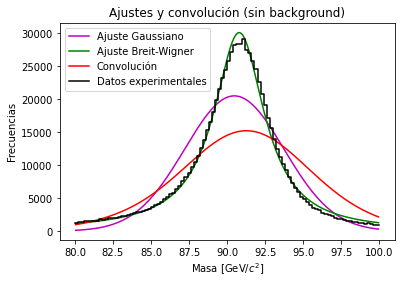

In [19]:
#@title
ConvolucionsinBgd = np.convolve(GAUSSIANyaxis, BWyaxis, mode='same')/sum(GAUSSIANyaxis)
plt.title('Ajustes y convolución (sin background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis, GAUSSIANyaxis, 'm',label='Ajuste Gaussiano') 
plt.plot(Masasxaxis, BWyaxis, 'g',label='Ajuste Breit-Wigner')
plt.plot(Masasxaxis, ConvolucionsinBgd, 'r',label='Convolución') 
bins, edges = np.histogram(data, 100)
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.legend()
plt.show()

## Ajuste Gaussiano con Background

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SmallIntegralWarning: (91.35164360520037, -4.9999999999999485, 1.0)
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SmallIntegralWarning: (91.35164360520037, 90.68237592657745, -0.2153786212427078)
  if __name__ == '__main__':


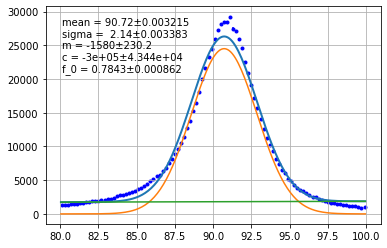

In [20]:
#@title

bgpdf1 = probfit.Normalized(linear,bound)
signal1pdf = probfit.Normalized(gaussian, bound)
total1_pdf = probfit.AddPdfNorm(signal1pdf,bgpdf1)
ulh1= UnbinnedLH(total1_pdf, data.values)
minuit_gaussian_Bgd = Minuit(ulh1, mean=90.5, sigma=3.0, c=1, f_0=0.7,m=10) #Function minimizer and error computer.

minuit_gaussian_Bgd.migrad()
ulh1.show(minuit_gaussian_Bgd,parts=True); #Grafica

((array([80.00017923, 80.2001743 , 80.40016936, 80.60016443, 80.80015949,
         81.00015456, 81.20014962, 81.40014469, 81.60013975, 81.80013482,
         82.00012988, 82.20012495, 82.40012001, 82.60011507, 82.80011014,
         83.0001052 , 83.20010027, 83.40009533, 83.6000904 , 83.80008546,
         84.00008053, 84.20007559, 84.40007066, 84.60006572, 84.80006079,
         85.00005585, 85.20005091, 85.40004598, 85.60004104, 85.80003611,
         86.00003117, 86.20002624, 86.4000213 , 86.60001637, 86.80001143,
         87.0000065 , 87.20000156, 87.39999663, 87.59999169, 87.79998675,
         87.99998182, 88.19997688, 88.39997195, 88.59996701, 88.79996208,
         88.99995714, 89.19995221, 89.39994727, 89.59994234, 89.7999374 ,
         89.99993247, 90.19992753, 90.3999226 , 90.59991766, 90.79991272,
         90.99990779, 91.19990285, 91.39989792, 91.59989298, 91.79988805,
         91.99988311, 92.19987818, 92.39987324, 92.59986831, 92.79986337,
         92.99985844, 93.1998535 , 93.

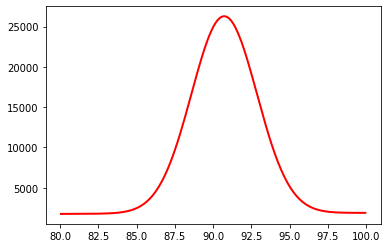

In [21]:
# @title
ulh1.draw(no_plot=True)

In [22]:
#@title
gaussianaruido=np.array([ 2155.32695884,  2151.29153648,  2147.26257518,  2143.24156975,
          2139.23033774,  2135.23108356,  2131.24647412,  2127.27972763,
          2123.33471777,  2119.41609524,  2115.52942937,  2111.68137236,
          2107.87984931,  2104.13427729,  2100.45581696,  2096.85766075,
          2093.35536159,  2089.96720661,  2086.7146405 ,  2083.62274317,
          2080.72076674,  2078.0427369 ,  2075.62812343,  2073.522585  ,
          2071.77879279,  2070.4573372 ,  2069.6277216 ,  2069.36944611,
          2069.77318374,  2070.94205003,  2072.99296615,  2076.05811357,
          2080.28647697,  2085.84546968,  2092.9226337 ,  2101.72740368,
          2112.49292132,  2125.47788352,  2140.96840414,  2159.27986568,
          2180.75873341,  2205.78430066,  2234.77032988,  2268.16655044,
          2306.45997018,  2350.17595417,  2399.87902107,  2456.17330432,
          2519.70262345,  2591.15010913,  2671.23732463,  2760.7228268 ,
          2860.40011073,  2971.09488474,  3093.66162623,  3228.97937366,
          3377.94671696,  3541.47595654,  3720.48641065,  3915.89686224,
          4128.61714885,  4359.53891332,  4609.52554831,  4879.40138393,
          5169.94018529,  5481.85304446,  5815.77576967,  6172.25589267,
          6551.73943324,  6954.55757662,  7380.91343549,  7830.86908268,
          8304.33305229,  8801.04851735,  9320.58235801,  9862.31533851,
         10425.4336104 , 11008.92175579, 11611.55757609, 12231.9088192 ,
         12868.33202151, 13518.97361993, 14181.773464  , 14854.47082912,
         15534.61299906, 16219.56645047, 16906.5306332 , 17592.55430025,
         18274.5542992 , 18949.33669477, 19613.62005006, 20264.06065349,
         20897.27943903, 21509.89031165, 22098.52955727, 22659.88598858,
         23190.73145514, 23687.95132906, 24148.57456678, 24569.80294318,
         24949.03905698, 25283.91271634, 25572.30532996, 25812.3719531 ,
         26002.56066746, 26141.62901034, 26228.65720973, 26263.05802815,
         26244.58306774, 26173.32544199, 26049.71877395, 25874.53253583,
         25648.86380022, 25374.12552657, 25052.03155791, 24684.57855066,
         24274.02510405, 23822.86839421, 23333.81865096, 22809.77184181,
         22253.78094761, 21669.02622735, 21058.7848754 , 20426.40047351,
         19775.25263204, 19108.7272004 , 18430.1874066 , 17742.9462598 ,
         17050.24051941, 16355.20649971, 15660.85794108, 14970.06613925,
         14285.54248184, 13609.82349963, 12945.25849782, 12293.99979129,
         11657.99552871, 11038.98505295, 10438.49671147,  9857.84799926,
          9298.14788996,  8760.30118822,  8245.01471696,  7752.80513954,
          7284.00820619,  6838.7892083 ,  6417.15442253,  6018.963328  ,
          5643.94138569,  5291.69317709,  4961.71571047,  4653.41171633,
          4366.10276881,  4099.04208628,  3851.42688202,  3622.41015383,
          3411.11181969,  3216.62912478,  3038.04626273,  2874.44317057,
          2724.90347315,  2588.52156689,  2464.40884645,  2351.69908948,
          2249.55302509,  2157.16212046,  2073.7516272 ,  1998.58293494,
          1930.95528406,  1870.20689215,  1815.71555107,  1766.89875165,
          1723.2133929 ,  1684.15513159,  1649.25742557,  1618.09032223,
          1590.25903987,  1565.40238672,  1543.19105852,  1523.32585157,
          1505.53582448,  1489.57643787,  1475.22769728,  1462.29232118,
          1450.59395218,  1439.97542639,  1430.29711295,  1421.4353327 ,
          1413.28086282,  1405.73753172,  1398.72090683,  1392.15707594,
          1385.9815216 ,  1380.13808681,  1374.57802907,  1369.25915949,
          1364.14506271,  1359.20439314,  1354.41024275,  1349.73957543])
Masasxaxis = np.array([80.050178  , 80.15017553, 80.25017306, 80.3501706 , 80.45016813,
         80.55016566, 80.65016319, 80.75016073, 80.85015826, 80.95015579,
         81.05015332, 81.15015086, 81.25014839, 81.35014592, 81.45014345,
         81.55014099, 81.65013852, 81.75013605, 81.85013358, 81.95013111,
         82.05012865, 82.15012618, 82.25012371, 82.35012124, 82.45011878,
         82.55011631, 82.65011384, 82.75011137, 82.85010891, 82.95010644,
         83.05010397, 83.1501015 , 83.25009903, 83.35009657, 83.4500941 ,
         83.55009163, 83.65008916, 83.7500867 , 83.85008423, 83.95008176,
         84.05007929, 84.15007683, 84.25007436, 84.35007189, 84.45006942,
         84.55006695, 84.65006449, 84.75006202, 84.85005955, 84.95005708,
         85.05005462, 85.15005215, 85.25004968, 85.35004721, 85.45004475,
         85.55004228, 85.65003981, 85.75003734, 85.85003487, 85.95003241,
         86.05002994, 86.15002747, 86.250025  , 86.35002254, 86.45002007,
         86.5500176 , 86.65001513, 86.75001267, 86.8500102 , 86.95000773,
         87.05000526, 87.15000279, 87.25000033, 87.34999786, 87.44999539,
         87.54999292, 87.64999046, 87.74998799, 87.84998552, 87.94998305,
         88.04998059, 88.14997812, 88.24997565, 88.34997318, 88.44997072,
         88.54996825, 88.64996578, 88.74996331, 88.84996084, 88.94995838,
         89.04995591, 89.14995344, 89.24995097, 89.34994851, 89.44994604,
         89.54994357, 89.6499411 , 89.74993864, 89.84993617, 89.9499337 ,
         90.04993123, 90.14992876, 90.2499263 , 90.34992383, 90.44992136,
         90.54991889, 90.64991643, 90.74991396, 90.84991149, 90.94990902,
         91.04990656, 91.14990409, 91.24990162, 91.34989915, 91.44989668,
         91.54989422, 91.64989175, 91.74988928, 91.84988681, 91.94988435,
         92.04988188, 92.14987941, 92.24987694, 92.34987448, 92.44987201,
         92.54986954, 92.64986707, 92.7498646 , 92.84986214, 92.94985967,
         93.0498572 , 93.14985473, 93.24985227, 93.3498498 , 93.44984733,
         93.54984486, 93.6498424 , 93.74983993, 93.84983746, 93.94983499,
         94.04983252, 94.14983006, 94.24982759, 94.34982512, 94.44982265,
         94.54982019, 94.64981772, 94.74981525, 94.84981278, 94.94981032,
         95.04980785, 95.14980538, 95.24980291, 95.34980044, 95.44979798,
         95.54979551, 95.64979304, 95.74979057, 95.84978811, 95.94978564,
         96.04978317, 96.1497807 , 96.24977824, 96.34977577, 96.4497733 ,
         96.54977083, 96.64976837, 96.7497659 , 96.84976343, 96.94976096,
         97.04975849, 97.14975603, 97.24975356, 97.34975109, 97.44974862,
         97.54974616, 97.64974369, 97.74974122, 97.84973875, 97.94973629,
         98.04973382, 98.14973135, 98.24972888, 98.34972641, 98.44972395,
         98.54972148, 98.64971901, 98.74971654, 98.84971408, 98.94971161,
         99.04970914, 99.14970667, 99.24970421, 99.34970174, 99.44969927,
         99.5496968 , 99.64969433, 99.74969187, 99.8496894 , 99.94968693])

In [23]:
#@title
#parámetros del ajuste gaussiano con background
media_Bgd = minuit_gaussian_Bgd.fitarg['mean'] 
sigma_Bgd = minuit_gaussian_Bgd.fitarg['sigma']
err_media_Bgd = minuit_gaussian_Bgd.fitarg['error_mean'] 
err_sigma_Bgd = minuit_gaussian_Bgd.fitarg['error_sigma']
minuit_gaussian_Bgd.fitarg

{'c': -299984.52755038714,
 'error_c': 43442.741146320004,
 'error_f_0': 0.0008620411239854076,
 'error_m': 230.20128562284143,
 'error_mean': 0.003215318695861693,
 'error_sigma': 0.0033828298423916013,
 'f_0': 0.7843306299507475,
 'fix_c': False,
 'fix_f_0': False,
 'fix_m': False,
 'fix_mean': False,
 'fix_sigma': False,
 'limit_c': None,
 'limit_f_0': None,
 'limit_m': None,
 'limit_mean': None,
 'limit_sigma': None,
 'm': -1580.0490972737698,
 'mean': 90.72342856485876,
 'sigma': 2.1399398200005093}

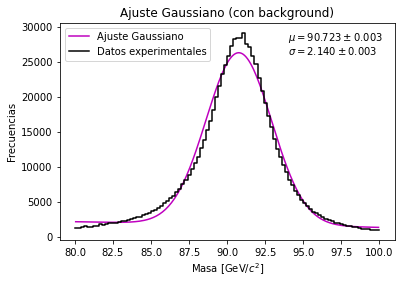

In [24]:
#@title
plt.figure()
plt.title('Ajuste Gaussiano (con background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis,gaussianaruido,c='m',label='Ajuste Gaussiano')
bins, edges = np.histogram(data, 100) #100 bins por default en el ajuste con minuit
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.text(94,28000,f'$\mu = {media_Bgd:.3f} \pm {err_media_Bgd:.3f}$')
plt.text(94,26000,f'$\sigma = {sigma_Bgd:.3f} \pm {err_sigma_Bgd:.3f}$')
plt.legend()
plt.show()

## Ajuste Breit-Wigner con Background

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SmallIntegralWarning: (91.35164360520037, 90.80608178046464, -9528.60015384594)
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SmallIntegralWarning: (91.35164360520037, 11.402175058800736, -138.01026603799318)
  if __name__ == '__main__':


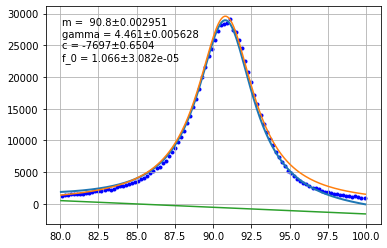

In [25]:
#@title
bound = (80,100)
data = datos['M'] 
bgpdf2 = probfit.Normalized(linear,bound)
signal2pdf = probfit.Normalized(rtv_breitwigner, bound)
total2_pdf = probfit.AddPdfNorm(signal2pdf,bgpdf2)
ulh2 = UnbinnedLH(total2_pdf, data.values)
minuit_BW_Bgd = Minuit(ulh2, m=90.5, gamma=3.0, c=1, f_0=0.7) #Function minimizer and error computer.
minuit_BW_Bgd.migrad() #Run Migrad minimization.
ulh2.show(minuit_BW_Bgd,parts=True); #Grafica

((array([80.00017923, 80.2001743 , 80.40016936, 80.60016443, 80.80015949,
         81.00015456, 81.20014962, 81.40014469, 81.60013975, 81.80013482,
         82.00012988, 82.20012495, 82.40012001, 82.60011507, 82.80011014,
         83.0001052 , 83.20010027, 83.40009533, 83.6000904 , 83.80008546,
         84.00008053, 84.20007559, 84.40007066, 84.60006572, 84.80006079,
         85.00005585, 85.20005091, 85.40004598, 85.60004104, 85.80003611,
         86.00003117, 86.20002624, 86.4000213 , 86.60001637, 86.80001143,
         87.0000065 , 87.20000156, 87.39999663, 87.59999169, 87.79998675,
         87.99998182, 88.19997688, 88.39997195, 88.59996701, 88.79996208,
         88.99995714, 89.19995221, 89.39994727, 89.59994234, 89.7999374 ,
         89.99993247, 90.19992753, 90.3999226 , 90.59991766, 90.79991272,
         90.99990779, 91.19990285, 91.39989792, 91.59989298, 91.79988805,
         91.99988311, 92.19987818, 92.39987324, 92.59986831, 92.79986337,
         92.99985844, 93.1998535 , 93.

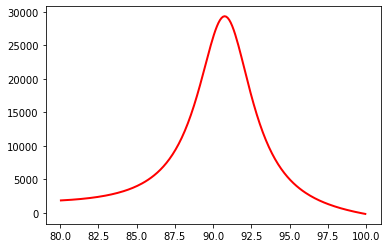

In [26]:
#@title
ulh2.draw(no_plot=True)

In [27]:
#@title
breitruido=np.array([ 1.87490255e+03,  1.88712489e+03,  1.89995455e+03,  1.91341302e+03,
          1.92752272e+03,  1.94230708e+03,  1.95779059e+03,  1.97399881e+03,
          1.99095849e+03,  2.00869760e+03,  2.02724541e+03,  2.04663253e+03,
          2.06689103e+03,  2.08805451e+03,  2.11015814e+03,  2.13323881e+03,
          2.15733520e+03,  2.18248789e+03,  2.20873945e+03,  2.23613458e+03,
          2.26472022e+03,  2.29454572e+03,  2.32566291e+03,  2.35812632e+03,
          2.39199332e+03,  2.42732428e+03,  2.46418276e+03,  2.50263573e+03,
          2.54275376e+03,  2.58461124e+03,  2.62828666e+03,  2.67386284e+03,
          2.72142721e+03,  2.77107213e+03,  2.82289517e+03,  2.87699952e+03,
          2.93349430e+03,  2.99249499e+03,  3.05412382e+03,  3.11851028e+03,
          3.18579158e+03,  3.25611315e+03,  3.32962927e+03,  3.40650363e+03,
          3.48690999e+03,  3.57103289e+03,  3.65906839e+03,  3.75122490e+03,
          3.84772401e+03,  3.94880144e+03,  4.05470803e+03,  4.16571080e+03,
          4.28209407e+03,  4.40416071e+03,  4.53223337e+03,  4.66665591e+03,
          4.80779482e+03,  4.95604076e+03,  5.11181021e+03,  5.27554712e+03,
          5.44772474e+03,  5.62884744e+03,  5.81945258e+03,  6.02011250e+03,
          6.23143641e+03,  6.45407235e+03,  6.68870902e+03,  6.93607756e+03,
          7.19695307e+03,  7.47215588e+03,  7.76255246e+03,  8.06905575e+03,
          8.39262476e+03,  8.73426333e+03,  9.09501757e+03,  9.47597192e+03,
          9.87824313e+03,  1.03029720e+04,  1.07513123e+04,  1.12244155e+04,
          1.17234121e+04,  1.22493869e+04,  1.28033486e+04,  1.33861922e+04,
          1.39986526e+04,  1.46412494e+04,  1.53142209e+04,  1.60174473e+04,
          1.67503616e+04,  1.75118495e+04,  1.83001390e+04,  1.91126818e+04,
          1.99460307e+04,  2.07957187e+04,  2.16561488e+04,  2.25205050e+04,
          2.33806975e+04,  2.42273578e+04,  2.50499010e+04,  2.58366678e+04,
          2.65751610e+04,  2.72523814e+04,  2.78552589e+04,  2.83711648e+04,
          2.87884780e+04,  2.90971635e+04,  2.92893171e+04,  2.93596225e+04,
          2.93056758e+04,  2.91281400e+04,  2.88307126e+04,  2.84199094e+04,
          2.79046882e+04,  2.72959517e+04,  2.66059808e+04,  2.58478478e+04,
          2.50348590e+04,  2.41800606e+04,  2.32958344e+04,  2.23935935e+04,
          2.14835779e+04,  2.05747420e+04,  1.96747204e+04,  1.87898557e+04,
          1.79252713e+04,  1.70849740e+04,  1.62719749e+04,  1.54884163e+04,
          1.47356979e+04,  1.40145969e+04,  1.33253786e+04,  1.26678951e+04,
          1.20416725e+04,  1.14459850e+04,  1.08799186e+04,  1.03424237e+04,
          9.83235843e+03,  9.34852407e+03,  8.88969315e+03,  8.45463176e+03,
          8.04211678e+03,  7.65094899e+03,  7.27996282e+03,  6.92803332e+03,
          6.59408091e+03,  6.27707438e+03,  5.97603250e+03,  5.69002455e+03,
          5.41817003e+03,  5.15963774e+03,  4.91364444e+03,  4.67945311e+03,
          4.45637110e+03,  4.24374800e+03,  4.04097359e+03,  3.84747564e+03,
          3.66271782e+03,  3.48619754e+03,  3.31744399e+03,  3.15601610e+03,
          3.00150072e+03,  2.85351083e+03,  2.71168380e+03,  2.57567985e+03,
          2.44518050e+03,  2.31988716e+03,  2.19951985e+03,  2.08381588e+03,
          1.97252878e+03,  1.86542712e+03,  1.76229360e+03,  1.66292403e+03,
          1.56712650e+03,  1.47472054e+03,  1.38553638e+03,  1.29941424e+03,
          1.21620365e+03,  1.13576287e+03,  1.05795831e+03,  9.82664016e+02,
          9.09761148e+02,  8.39137549e+02,  7.70687312e+02,  7.04310383e+02,
          6.39912197e+02,  5.77403332e+02,  5.16699190e+02,  4.57719701e+02,
          4.00389044e+02,  3.44635390e+02,  2.90390661e+02,  2.37590303e+02,
          1.86173079e+02,  1.36080870e+02,  8.72584967e+01,  3.96535413e+01,
         -6.78380652e+00, -5.21009015e+01, -9.63427827e+01, -1.39552304e+02])

Masasxaxixs = np.array([80.050178  , 80.15017553, 80.25017306, 80.3501706 , 80.45016813,
         80.55016566, 80.65016319, 80.75016073, 80.85015826, 80.95015579,
         81.05015332, 81.15015086, 81.25014839, 81.35014592, 81.45014345,
         81.55014099, 81.65013852, 81.75013605, 81.85013358, 81.95013111,
         82.05012865, 82.15012618, 82.25012371, 82.35012124, 82.45011878,
         82.55011631, 82.65011384, 82.75011137, 82.85010891, 82.95010644,
         83.05010397, 83.1501015 , 83.25009903, 83.35009657, 83.4500941 ,
         83.55009163, 83.65008916, 83.7500867 , 83.85008423, 83.95008176,
         84.05007929, 84.15007683, 84.25007436, 84.35007189, 84.45006942,
         84.55006695, 84.65006449, 84.75006202, 84.85005955, 84.95005708,
         85.05005462, 85.15005215, 85.25004968, 85.35004721, 85.45004475,
         85.55004228, 85.65003981, 85.75003734, 85.85003487, 85.95003241,
         86.05002994, 86.15002747, 86.250025  , 86.35002254, 86.45002007,
         86.5500176 , 86.65001513, 86.75001267, 86.8500102 , 86.95000773,
         87.05000526, 87.15000279, 87.25000033, 87.34999786, 87.44999539,
         87.54999292, 87.64999046, 87.74998799, 87.84998552, 87.94998305,
         88.04998059, 88.14997812, 88.24997565, 88.34997318, 88.44997072,
         88.54996825, 88.64996578, 88.74996331, 88.84996084, 88.94995838,
         89.04995591, 89.14995344, 89.24995097, 89.34994851, 89.44994604,
         89.54994357, 89.6499411 , 89.74993864, 89.84993617, 89.9499337 ,
         90.04993123, 90.14992876, 90.2499263 , 90.34992383, 90.44992136,
         90.54991889, 90.64991643, 90.74991396, 90.84991149, 90.94990902,
         91.04990656, 91.14990409, 91.24990162, 91.34989915, 91.44989668,
         91.54989422, 91.64989175, 91.74988928, 91.84988681, 91.94988435,
         92.04988188, 92.14987941, 92.24987694, 92.34987448, 92.44987201,
         92.54986954, 92.64986707, 92.7498646 , 92.84986214, 92.94985967,
         93.0498572 , 93.14985473, 93.24985227, 93.3498498 , 93.44984733,
         93.54984486, 93.6498424 , 93.74983993, 93.84983746, 93.94983499,
         94.04983252, 94.14983006, 94.24982759, 94.34982512, 94.44982265,
         94.54982019, 94.64981772, 94.74981525, 94.84981278, 94.94981032,
         95.04980785, 95.14980538, 95.24980291, 95.34980044, 95.44979798,
         95.54979551, 95.64979304, 95.74979057, 95.84978811, 95.94978564,
         96.04978317, 96.1497807 , 96.24977824, 96.34977577, 96.4497733 ,
         96.54977083, 96.64976837, 96.7497659 , 96.84976343, 96.94976096,
         97.04975849, 97.14975603, 97.24975356, 97.34975109, 97.44974862,
         97.54974616, 97.64974369, 97.74974122, 97.84973875, 97.94973629,
         98.04973382, 98.14973135, 98.24972888, 98.34972641, 98.44972395,
         98.54972148, 98.64971901, 98.74971654, 98.84971408, 98.94971161,
         99.04970914, 99.14970667, 99.24970421, 99.34970174, 99.44969927,
         99.5496968 , 99.64969433, 99.74969187, 99.8496894 , 99.94968693])

In [28]:
#@title
#se extran los valores del ajuste a Breit-Wigner
gamma_Bgd = minuit_BW_Bgd.fitarg['gamma'] 
m_Bgd = minuit_BW_Bgd.fitarg['m']
err_gamma_Bgd = minuit_BW_Bgd.fitarg['error_gamma'] 
err_m_Bgd = minuit_BW_Bgd.fitarg['error_m']
minuit_BW_Bgd.fitarg

{'c': -7697.076783897501,
 'error_c': 0.6503572519110978,
 'error_f_0': 3.082183873747768e-05,
 'error_gamma': 0.005627914555623313,
 'error_m': 0.002950756010760075,
 'f_0': 1.0657228458238739,
 'fix_c': False,
 'fix_f_0': False,
 'fix_gamma': False,
 'fix_m': False,
 'gamma': 4.460724271576588,
 'limit_c': None,
 'limit_f_0': None,
 'limit_gamma': None,
 'limit_m': None,
 'm': 90.80348524568394}

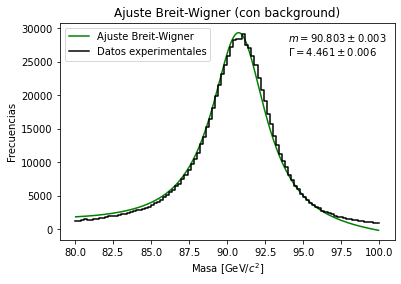

In [29]:
#@title
plt.figure()
plt.title('Ajuste Breit-Wigner (con background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis,breitruido,c='g',label='Ajuste Breit-Wigner')
bins, edges = np.histogram(data, 100) #100 bins por default en el ajuste con minuit
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.text(94,28000,f'$m = {m_Bgd:.3f} \pm {err_m_Bgd:.3f}$')
plt.text(94,26000,f'$\Gamma = {gamma_Bgd:.3f} \pm {err_gamma_Bgd:.3f}$')
plt.legend()
plt.show()

## Convolución de Ajustes Gaussiano y Breit-Wigner con ruido, método numérico

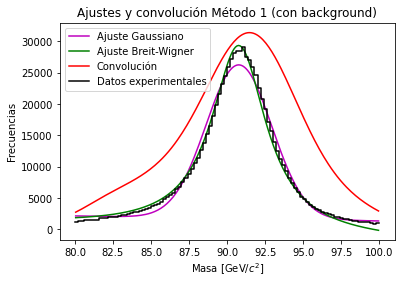

In [30]:
#@title
convolucionconruidonumerico = scipy.signal.convolve(gaussianaruido, breitruido,mode='same')/900000

plt.title('Ajustes y convolución Método 1 (con background)')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
plt.plot(Masasxaxis, gaussianaruido, 'm',label='Ajuste Gaussiano') 
plt.plot(Masasxaxis, breitruido, 'g',label='Ajuste Breit-Wigner')
plt.plot(Masasxaxis, convolucionconruidonumerico, 'r',label='Convolución') 
bins, edges = np.histogram(data, 100)
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.legend()
plt.show()

## Convolución de Ajustes Gaussiano y Breit-Wigner con ruido, método analítico

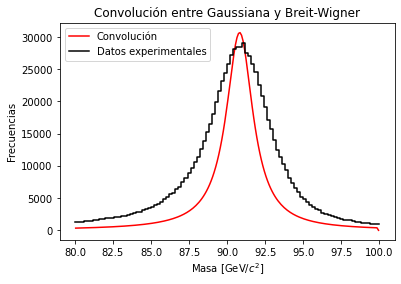

In [58]:
#@title
bound=(-100000,100000)
gaussianafuncion = lambda x, mean, sigma: gaussian(x,mean,sigma)
breitfuncion= lambda x, m, gamma: rtv_breitwigner(x,m,gamma)
convolucionanalitica = Convolve(breitfuncion,gaussianafuncion,bound)
convolucionconruido=lambda x:  convolucionanalitica(x+100,90.723,2.140,90.803,4.461)
convolucionconruidoarray=np.empty(200)
for j in range(0, 199):
    convolucionconruidoarray[j]=(15**4)*convolucionconruido(Masasxaxis[j])


plt.title('Convolución entre Gaussiana y Breit-Wigner')
plt.xlabel('Masa [GeV/$c^{2}$]')
plt.ylabel('Frecuencias')
#plt.plot(Masasxaxis, gaussianaruido, 'm',label='Ajuste Gaussiano') 
#plt.plot(Masasxaxis, breitruido, 'g',label='Ajuste Breit-Wigner')
plt.plot(Masasxaxis, convolucionconruidoarray, 'r',label='Convolución') 
bins, edges = np.histogram(data, 100)
left, right = edges[:-1], edges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([bins, bins]).T.flatten()
plt.plot(X, Y,label='Datos experimentales',c='k')
plt.legend()
plt.show()

## Método BLUE




$\overline{M}=\alpha_1M_1+\alpha_2M_2\ \text{(Combinación lineal de masas experimentales)}$

 $\alpha_1+\alpha_2=1$

 $E=\left(\begin{matrix}\sigma_1^2& r \sigma_1 \sigma_2 \\r \sigma_1 \sigma_2 & \sigma_2^2 \end{matrix}\right)\ \text{(Matriz de Errores)}$

$\sigma_2 > \sigma_1$



In [32]:
datoselectron = pd.read_csv('drive/MyDrive/datos.csv', sep='|')
datoselectron['p1'] = datoselectron['Pt1']*np.cosh(datoselectron['eta1'])
datoselectron['p2'] = datoselectron['Pt2']*np.cosh(datoselectron['eta2'])
me=0.00510998928
datoselectron['E1'] = np.sqrt(datoselectron['p1']**2+me**2)
datoselectron['E2'] = np.sqrt(datoselectron['p2']**2+me**2)
datoselectron['p1x']=datoselectron['Pt1']*np.cos(datoselectron['phi1'])  ##PHI ESTA EN RADIANES O GRADOS? PT está en que unidades?
datoselectron['p2x']=datoselectron['Pt2']*np.cos(datoselectron['phi2'])
datoselectron['ptotalx']=datoselectron['p1x']+datoselectron['p2x']

datoselectron['p1y']=datoselectron['Pt1']*np.sin(datoselectron['phi1']) 
datoselectron['p2y']=datoselectron['Pt2']*np.sin(datoselectron['phi2'])
datoselectron['ptotaly']=datoselectron['p1y']+datoselectron['p2y']

datoselectron['p1z']=datoselectron['Pt1']*np.sinh(datoselectron['eta1']) 
datoselectron['p2z']=datoselectron['Pt2']*np.sinh(datoselectron['eta2'])
datoselectron['ptotalz']=datoselectron['p1z']+datoselectron['p2z']
datoselectron['M']=np.sqrt((datoselectron['E1']+datoselectron['E2'])**2-(datoselectron['ptotalx'])**2-(datoselectron['ptotaly'])**2-(datoselectron['ptotalz'])**2)
datoselectron.head()

,Pt1,eta1,phi1,charge1,Pt2,eta2,phi2,charge2,p1,p2,E1,E2,p1x,p2x,ptotalx,p1y,p2y,ptotaly,p1z,p2z,ptotalz,M
0,60.575401,-0.489570,1.049597,-1,36.290058,-0.837253,-1.585917,1,67.980876,49.770200,67.980876,49.770200,30.161738,-0.548705,29.613033,52.532360,-36.285910,16.246450,-30.854825,-34.060306,-64.915131,92.252169
1,38.580242,-0.772801,-1.579755,-1,38.480286,0.141090,1.526704,1,50.685617,38.863922,50.685617,38.863923,-0.345607,1.696133,1.350525,-38.578694,38.442886,-0.135808,-32.872430,5.447208,-27.425222,85.235761
2,66.590759,0.209339,-0.624676,1,33.051304,1.084194,1.387852,-1,68.055187,54.455817,68.055187,54.455817,54.015283,6.012890,60.028173,-38.944556,32.499751,-6.444805,14.042052,43.278717,57.320768,89.879690
3,35.633781,1.972931,1.976611,-1,35.170387,1.317354,-1.305447,1,130.611575,70.364907,130.611575,70.364907,-14.067060,9.223320,-4.843740,32.739643,-33.939454,-1.199811,125.656743,60.944762,186.601505,74.474985
4,62.597717,-2.168633,-2.127519,1,42.711926,-1.845638,-0.044009,-1,277.328464,138.601532,277.328464,138.601532,-33.077068,42.670570,9.593502,-53.144913,-1.879107,-55.024021,-270.171433,-131.856270,-402.027703,90.839473


In [33]:
datoselectron2 = datoselectron['M'][(abs(datoselectron['M'] >= 80)) & (abs(datoselectron['M'] <= 100))]

In [34]:
#se calcula el coef. de correlación

#datos
Masaexperimental1=90.803
Masaexperimental2=91.3

sigma1=2.140
sigma2=2.33

datam_0=np.zeros(len(datoselectron2)) #se cortan los datos para que tengan misma longitud 

for k in range (len(datoselectron2)):
    datam_0[k] = data.values[k]
    
rho = np.corrcoef(datam_0, datoselectron2) #matriz de correlacion

print('Correlation matrix')
rho

Correlation matrix


array([[ 1.        , -0.00256381],
       [-0.00256381,  1.        ]])

In [35]:
#matriz de error:
E=np.zeros((2,2))

E[0,0]=sigma1**2
E[1,1]=sigma2**2
E[1,0]=sigma1*sigma2*rho[0,1]
E[0,1]=sigma1*sigma2*rho[0,1]

print('Error matrix')
E

Error matrix


array([[ 4.5796    , -0.01278366],
       [-0.01278366,  5.4289    ]])

In [36]:
ErrorMatrix = blue.CovarianceMatrix(
    [[E[0,0],E[0,1]],
     [E[1,0],E[1,1]],
     ]
)
ErrorMatrix

CovarianceMatrix([[ 4.5796    , -0.01278366],
                  [-0.01278366,  5.4289    ]])

In [37]:
#BLUE
measurements = blue.Measurements([Masaexperimental1,Masaexperimental2])
comb = blue.BLUE(measurements, ErrorMatrix)
print()
print('BLUE result:')
print(comb)


BLUE result:
weights = [[0.54232082 0.45767918]]
result = 91.0305 +- 1.57409
